## Part 3 : Predictive Analysis


Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
    
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
    
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

## Data Description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

In [120]:
import numpy as np
import pandas as pd
import json
import shap

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
#sns.set()

In [90]:
def plot_auc_curve(y_test, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [109]:
def plot_impfeatures(models, model_label, ncol=None):
    if ncol is None:
        ncol = 2
    nrow = int(np.ceil(len(models) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8*nrow), squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, model in enumerate(models):
        ax = axes.flatten()[i]
        print(model)
        importances = model.feature_importances_
        indices = np.argsort(importances)
        features = X_train.columns
        
        ax.barh(range(len(indices)), importances[indices], color='b', align='center')
        ax.set(title=model_label[i])
        ax.set(xlabel='Relative Importance')
        ax.set_yticks(range(len(indices)), [features[i] for i in indices])
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [59]:
def plot_confusion_matrix(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);

In [78]:
def plot_auc_and_cm(y_test, y_pred):
    ncol = 2
    nrow = 1
    
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 5*nrow), squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    
    ax = axes.flatten()[0]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    score = metrics.auc(fpr, tpr)
    ax.set(title='Receiver Operating Characteristic')
    ax.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % score)
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    
    ax = axes.flatten()[1]
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    ax.set_ylabel('Actual label');
    ax.set_xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: %0.4f' % score
    ax.set(title = all_sample_title);

In [104]:
def auc_score(model, y_test, X_test):
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    return auc_score

In [118]:
def shap_values(model):
    explainer = shap.Explainer(model.predict,X_train[0:100])
    shap_values = explainer(X_test)
    return shap_values

## 3.1 Exploratory Data Analysis

In [131]:
file1 = 'ultimate_data_challenge.json'

In [158]:
df = pd.read_json(file1)
df1 = df

In [133]:
df1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [10]:
df1.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


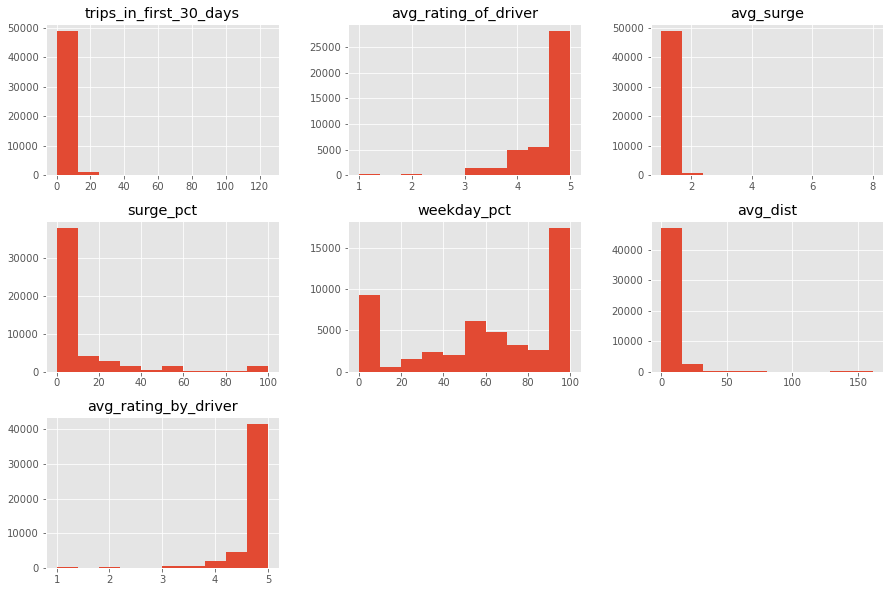

In [11]:
df1.hist(figsize=(15,10))
plt.show()

In [12]:
# Missing Data

missing = pd.DataFrame([df1.isnull().sum(), 100 * df1.isnull().mean()]).T
missing.columns=['count','%']
missing.sort_values(by='count', ascending = False)

,count,%
avg_rating_of_driver,8122.0,16.244
phone,396.0,0.792
avg_rating_by_driver,201.0,0.402
city,0.0,0.000
trips_in_first_30_days,0.0,0.000
signup_date,0.0,0.000
avg_surge,0.0,0.000
last_trip_date,0.0,0.000
surge_pct,0.0,0.000
ultimate_black_user,0.0,0.000


Three columns have null values avg_rating_of_driver, phone and avg_rating_by driver. Not surprising, because these data are not in the control of companies and have to rely on usr input.

In [13]:
# Let's check the phone data
df1['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

Looks like most users have iphone and android and 396 are missing values. Lets populate the missing values with 'Other'

In [14]:
# Filling null values with Other
df1['phone'].fillna('Other', inplace = True)

In [15]:
df1['phone'].value_counts()

iPhone     34582
Android    15022
Other        396
Name: phone, dtype: int64

In [16]:
# Let's fill the Nan in rating column by median

df1[['avg_rating_by_driver', 'avg_rating_of_driver']] = df1[['avg_rating_by_driver', 'avg_rating_of_driver']].fillna(df1[['avg_rating_by_driver', 'avg_rating_of_driver']].median())

In [17]:
df1.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

No null values in any column

In [18]:
# Check for datetime entries
df1.signup_date[0]


'2014-01-25'

In [19]:
df1.last_trip_date[0]

'2014-06-17'

Both of them are string so we will convert them to datetime object

In [20]:
# Converting these to date column into datetime
df1['signup_date'] = pd.to_datetime(df1['signup_date'])
df1['last_trip_date'] = pd.to_datetime(df1['last_trip_date'])

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [22]:
max(df1.last_trip_date)

Timestamp('2014-07-01 00:00:00')

Now let's create a column to see how many users were retained. Since July 1 was the last date anyone who took trip on June 1 or later were considered retained.

In [23]:
# Retained user
df1['retained'] = (df1.last_trip_date >= '2014-06-01')*1

In [24]:
# Percentage of retained

per_retained = ((df1['retained']).sum()/df1['retained'].count())*100
per_retained

37.608000000000004

In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  retained                50000 non-null  int64 

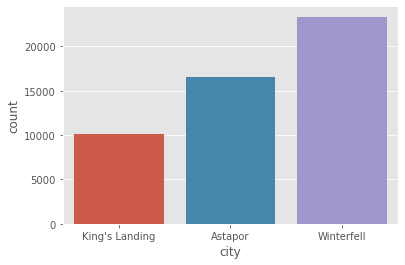

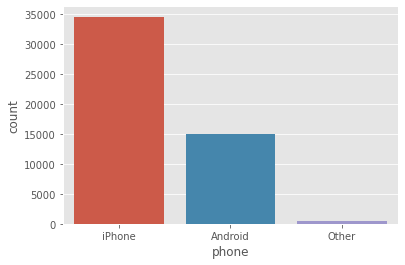

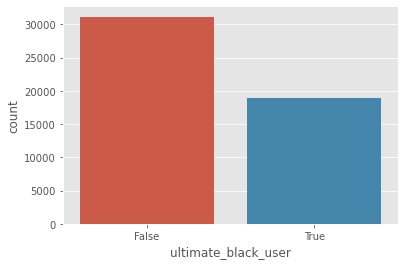

In [26]:
# Let's look at the histogram of categorical data

cat_cols = ['city','phone', 'ultimate_black_user']
for cols in cat_cols:
    plt.figure()
    sns.countplot(df1[cols])

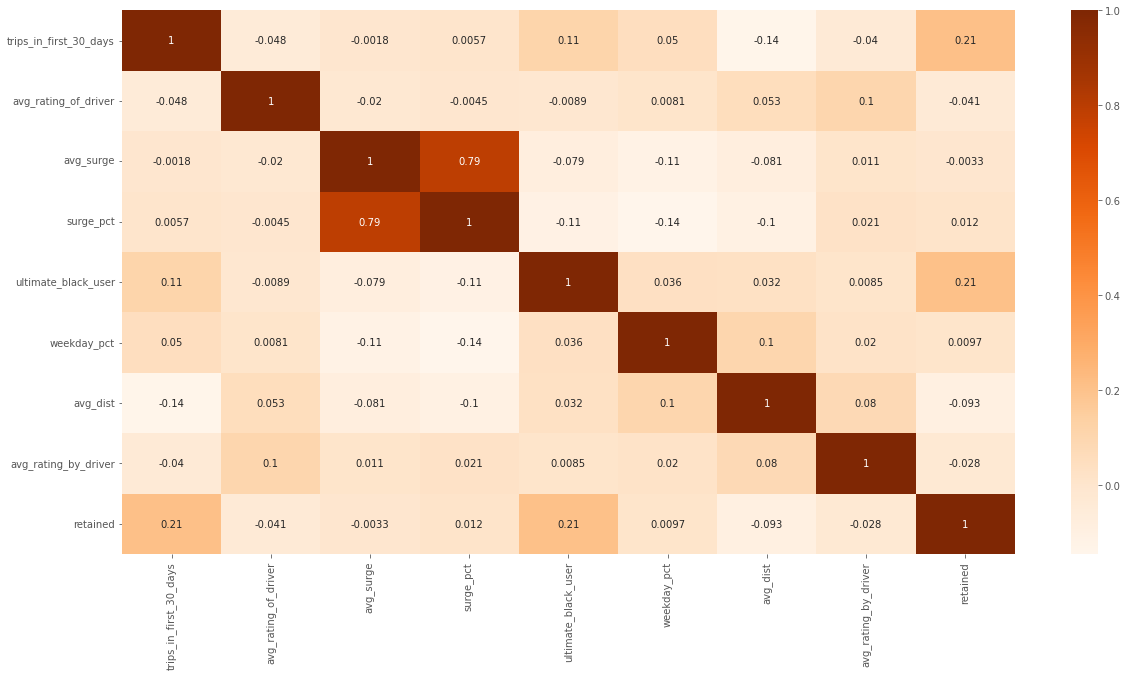

In [27]:
# Check for correlation among data
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df1.corr(), annot=True, cmap="Oranges" ,ax = ax)
plt.show()

In [28]:
df1.corr()['retained'].sort_values(ascending = False)

retained                  1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_by_driver     -0.027548
avg_rating_of_driver     -0.041082
avg_dist                 -0.092780
Name: retained, dtype: float64

We can see this has ignored categorical data. We will do this correlation analysis once again after encoding the categorical data to numerical.

## 3.2 Preprocessing data

In [29]:
## Let's convert the categorical data into numerical using OheHotEncoder
from sklearn.preprocessing import OneHotEncoder

In [30]:
# For ultimate_black_user since it is boolean data we can use int() to convert into 1 and 0

df1['ultimate_black_user'] = df1['ultimate_black_user'].astype(int)
df1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0


In [31]:
# For phone and city we will use the OneHotEncoder

#First: For city
ohe = OneHotEncoder()
city_data = ohe.fit_transform(df1[['city']])
city_cols = ohe.get_feature_names_out()

df_city = pd.DataFrame(city_data.toarray(), columns=city_cols) 

df1 = pd.concat([df1, df_city], axis=1)
df1.drop('city', axis=1, inplace=True)
            
df1.head()


,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell
0,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1,0.0,1.0,0.0
1,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0,1.0,0.0,0.0
2,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0,1.0,0.0,0.0
3,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1,0.0,1.0,0.0
4,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0,0.0,0.0,1.0


In [32]:
# Second: For phone

phone_data = ohe.fit_transform(df1[['phone']])
phone_cols = ohe.get_feature_names_out()

df_phone = pd.DataFrame(phone_data.toarray(), columns=phone_cols) 

df1 = pd.concat([df1, df_phone], axis=1)
df1.drop('phone', axis=1, inplace=True)
            
df1.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,1,0.0,1.0,0.0,0.0,0.0,1.0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,0,1.0,0.0,0.0,0.0,0.0,1.0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,0.0,1.0,0.0,0.0,0.0,1.0
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0.0,0.0,1.0,1.0,0.0,0.0


In [51]:
df1.corr()['retained'].sort_values(ascending = False)

retained                  1.000000
city_King's Landing       0.262284
phone_iPhone              0.225244
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
phone_Other              -0.007419
avg_rating_by_driver     -0.027548
avg_rating_of_driver     -0.041082
city_Winterfell          -0.046611
avg_dist                 -0.092780
city_Astapor             -0.174655
phone_Android            -0.225464
Name: retained, dtype: float64

In [33]:
# Data looks pretty clean now. Let's separate the data into target and features

X = df1.drop(['retained','signup_date','last_trip_date'], axis = 1)
y = df1['retained']

In [34]:
# Let's split the data into training and testing set

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn import metrics


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [50]:
# Let's scale the train and test data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## 3.3 Model Selection and Training

### 3.3.1 Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

LR_pipe = LogisticRegression()
LR_pipe.fit(X_train, y_train);
model_name = LR_pipe
model_name.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [53]:
grid_params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
lr_grid_cv = GridSearchCV(model_name, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train);
lr_grid_cv.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [54]:
lr2=LogisticRegression(C=0.001,penalty="l2")
lr2.fit(X_train,y_train)
print("score",lr2.score(X_test,y_test))

score 0.7174545454545455


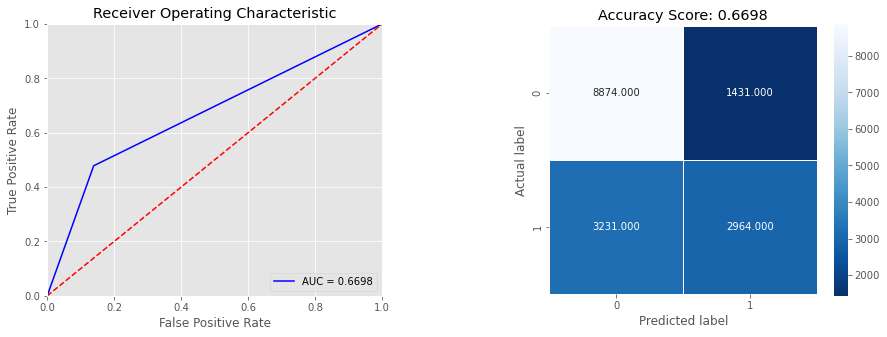

In [80]:
y_pred_lr2 = lr2.predict(X_test)
plot_auc_and_cm(y_test, y_pred_lr2)

### 3.3.2 Random Forest

In [82]:
from sklearn.ensemble import RandomForestRegressor

# Model Build and fit

RF_pipe = RandomForestRegressor()
RF_pipe.fit(X_train, y_train);
model_name = RF_pipe
model_name.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [89]:
# Hyperparameter Tuning

grid_params = { 'n_estimators': [50, 100],'max_features': ['sqrt', 'log2']}
rf_grid_cv = GridSearchCV(model_name, param_grid=grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train);
rf_grid_cv.best_params_

{'max_features': 'sqrt', 'n_estimators': 100}

In [86]:
# Model Tuneup using best params

rf2=RandomForestRegressor(max_features = 'log2', n_estimators= 100)
rf2.fit(X_train,y_train)
print("score",rf2.score(X_test,y_test))

score 0.27569607882714353


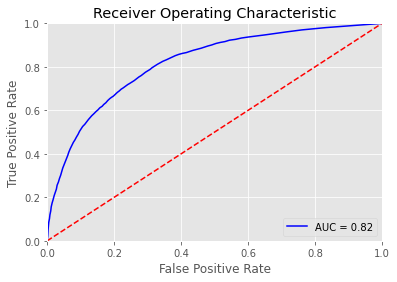

In [91]:
# Prediction and score
y_pred_rf2 = rf2.predict(X_test)
plot_auc_curve(y_test, y_pred_rf2)

### 3.3.3 XGBoost

In [92]:
from xgboost import XGBRegressor

# Model Build and fit

xg_pipe = XGBRegressor()
xg_pipe.fit(X_train, y_train);
model_name = xg_pipe
model_name.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [93]:
# Hyperparameter Tuning

grid_params = {'learning_rate': [0.001, 0.01, 0.1],
                'max_depth': [5, 10, 15]}
xg_grid_cv = GridSearchCV(model_name, param_grid=grid_params, cv=5, n_jobs=-1)
xg_grid_cv.fit(X_train, y_train);
xg_grid_cv.best_params_

/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future versio

{'learning_rate': 0.1, 'max_depth': 5}

In [95]:
# Model Tuneup using best params

xg2=XGBRegressor(learning_rate = 0.1, max_depth= 5)
xg2.fit(X_train,y_train)
print("score",xg2.score(X_test,y_test))

score 0.368725925005555


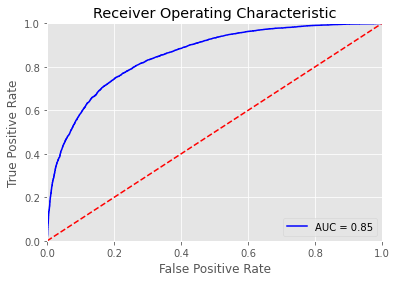

In [97]:
y_pred_xg2 = xg2.predict(X_test)
plot_auc_curve(y_test, y_pred_xg2)

### 3.3.4 KNN Classifier

In [98]:
from sklearn.neighbors import KNeighborsClassifier

# Model Build and fit

knn_pipe = KNeighborsClassifier()
knn_pipe.fit(X_train, y_train);
model_name = knn_pipe
model_name.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [99]:
# Hyperparameter Tuning

grid_params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8]}
knn_grid_cv = GridSearchCV(model_name, param_grid=grid_params, cv=5, n_jobs=-1)
knn_grid_cv.fit(X_train, y_train);
knn_grid_cv.best_params_

/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

{'n_neighbors': 8}

In [100]:
# Model Tuneup using best params

knn2=KNeighborsClassifier(n_neighbors= 8)
knn2.fit(X_train,y_train)
print("score",knn2.score(X_test,y_test))

score 0.7506060606060606


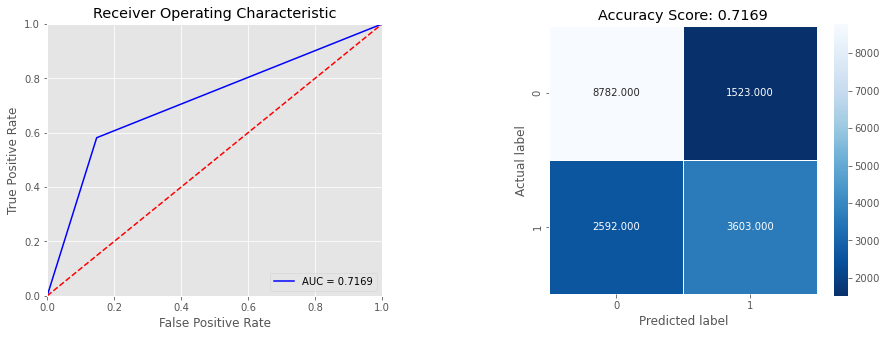

In [101]:
y_pred_knn2 = knn2.predict(X_test)
plot_auc_and_cm(y_test, y_pred_knn2)

## 4 Compare different Models

In [102]:
model = [lr2, rf2, xg2, knn2 ]
model_name =['LogisticRegression', 'RandomForest', 'XGBoost', 'KNN']

In [105]:
#AUC Score
for i, name in enumerate(model):
    val = auc_score(model[i], y_test, X_test)
    print('The AUC Socre for %s is %.4f' % (model_name[i],val))

The AUC Socre for LogisticRegression is 0.6698
The AUC Socre for RandomForest is 0.8174
The AUC Socre for XGBoost is 0.8545
The AUC Socre for KNN is 0.7169


## 5 Model Interpretation

In [128]:
# Pick the best model

best_model = xg2
best_model_name ='XGBoost'

In [130]:
# Check importnat features
best_model.feature_importances_

array([0.01783727, 0.01297916, 0.01865078, 0.11336534, 0.08566427,
       0.04697623, 0.01064144, 0.19427964, 0.06901093, 0.2156435 ,
       0.00777783, 0.13070779, 0.00531196, 0.07115384], dtype=float32)

In [168]:
# Let's rerun this model to extarct the feature importance by name.
df = pd.read_json(file1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [169]:
# Let's cleanup and prepare the data

# Retained user
df['retained'] = (df.last_trip_date >= '2014-06-01')*1

# Change boolean to integer
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

# Filling null values with Other for phone
df['phone'].fillna('Other', inplace = True)


# Let's fill the NaN in rating column by median

df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())

# Let's drop date column
df.drop(['signup_date','last_trip_date'], axis = 1, inplace = True)

df['city'] = df['city'].astype('category')
df['phone'] = df['phone'].astype('category')

df = pd.get_dummies(df)
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0,0


In [170]:
# Split data

X = df.drop(['retained'], axis=1)
y = df['retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [171]:
final_model=XGBRegressor(learning_rate = 0.1, max_depth= 5)

final_model.fit(X_train,y_train)
print("score",final_model.score(X_test,y_test))

score 0.3799429029364826


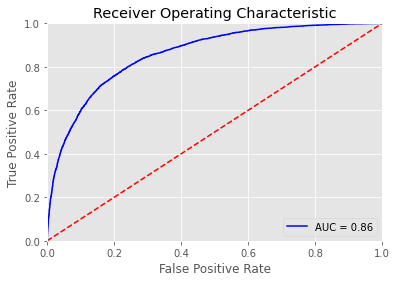

In [172]:
y_pred = final_model.predict(X_test)
plot_auc_curve(y_test, y_pred)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


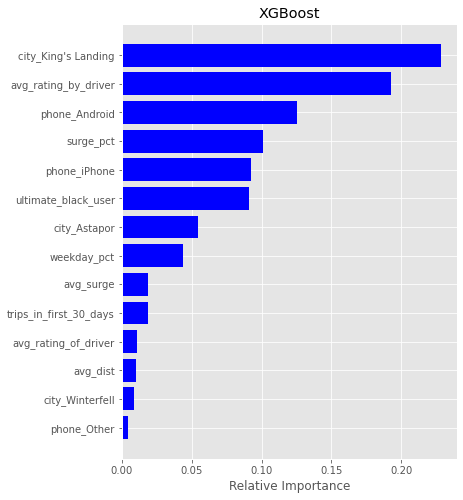

In [176]:
plot_impfeatures([final_model], ['XGBoost'])